## Vehicle Detection Project

We will first train a classifier on the extended labeled dataset.

In [2]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
import glob
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split

%matplotlib inline

/usr/local/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from helper_functions import *

In order to train the classifier, we will need to play around with the parameters for how we are going to transform the features. One important feature vector is going to be the one coming from the Histogram of Gradients. In order to figure out good parameters for that, we will use a small visualization widget to see how different parameters affect the output image.

In [4]:
from IPython.html import widgets
from IPython.html.widgets import interact, fixed
from IPython.display import display

/usr/local/miniconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


/usr/local/miniconda3/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


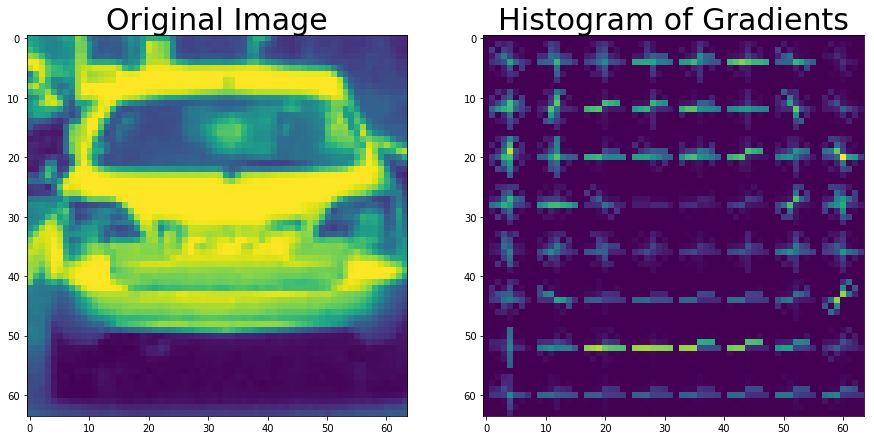

<function __main__.interactive_hog>

In [5]:
image = mpimg.imread('test_images/car.png')
image = scale_img(image)

def interactive_hog(colorspace, channel, orient, pix_per_cell, cell_per_block, transform_sqrt):
    transformed_img = np.copy(image)
    
    if colorspace == 1: # RGB
        transformed_img = transformed_img[:,:,channel]
    elif colorspace == 2: # GRAYSCALE
        transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2GRAY)
    elif colorspace == 3: # HSV
        transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2HSV)
        transformed_img = transformed_img[:,:,channel]
    elif colorspace == 4: # HLS
        transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2HLS)
        transformed_img = transformed_img[:,:,channel]
    elif colorspace == 5: # LUV
        transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2LUV)
        transformed_img = transformed_img[:,:,channel]
    elif colorspace == 6: # YUV
        transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2YUV)
        transformed_img = transformed_img[:,:,channel]
    elif colorspace == 7: # YCrCb
        transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2YCrCb)
        transformed_img = transformed_img[:,:,channel]
    
    _, hog_img = get_hog_features(transformed_img, orient, pix_per_cell, cell_per_block, \
                                  vis=True, transform_sqrt=transform_sqrt)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    
    ax1.imshow(transformed_img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(hog_img)
    ax2.set_title('Histogram of Gradients', fontsize=30)
    plt.show()

interact(interactive_hog, colorspace=(1, 7), channel=(0, 2), orient=(1, 20), pix_per_cell=(2, 15), cell_per_block=(1, 15), transform_sqrt=False)

In [16]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [17]:
# Read in cars and notcars
cars = glob.glob('big-data-set/vehicles/**/*.png', recursive=True)
notcars = glob.glob('big-data-set/non-vehicles/**/*.png', recursive=True)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
# sample_size = 1000
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

print("Number of Car Images: ", len(cars))
print("Number of Not Car Images: ", len(notcars))

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Number of Car Images:  8792
Number of Not Car Images:  8968


/usr/local/miniconda3/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
21.84 Seconds to train SVC...
Test Accuracy of SVC =  0.9907


With the classifier trained, let's check the results on some test images

In [18]:
# Scale PNG images read through matplotlib, since they are being read on a scale from
# 0 to 1 and we need them to be on a scale from 0 to 255
def scale_img(image):
    image = image * 255
    image = image.astype(np.uint8)

    return image

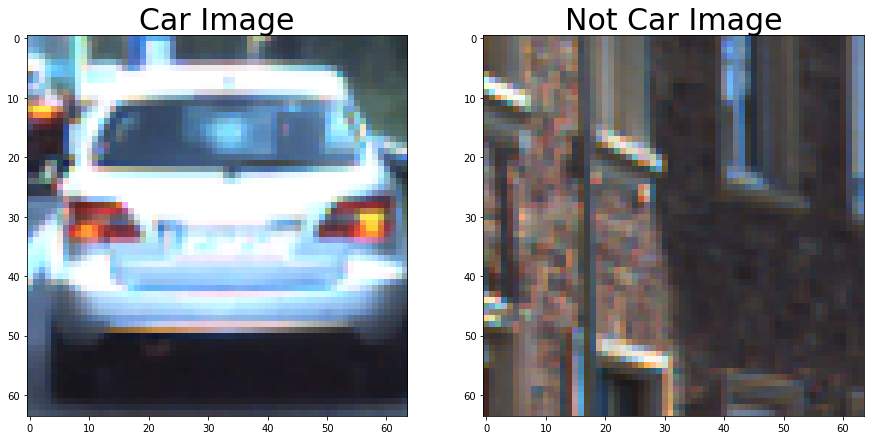

In [19]:
car_img = mpimg.imread('test_images/car.png')
notcar_img = mpimg.imread('test_images/notcar.png')

# Scale the image, since matplotlib reads PNG images on a scale of 0 to 1
car_img = scale_img(car_img)
notcar_img = scale_img(notcar_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

ax1.imshow(car_img)
ax1.set_title("Car Image", fontsize=30)
ax2.imshow(notcar_img)
ax2.set_title("Not Car Image", fontsize=30)
plt.show()

Now let's grab the features for these images, scale them and pass them to the classifier.

In [20]:
car_features = single_img_features(car_img, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = single_img_features(notcar_img, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)

# Scale extracted features to be fed to classifier
scaled_car_features = X_scaler.transform(np.array(car_features).reshape(1, -1))
scaled_notcar_features = X_scaler.transform(np.array(notcar_features).reshape(1, -1))

#6) Predict using your classifier
car_prediction = svc.predict(scaled_car_features)
notcar_prediction = svc.predict(scaled_notcar_features)

print("Prediction for Car Image: ", car_prediction)
print("Prediction for Not Car Image: ", notcar_prediction)

/usr/local/miniconda3/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Prediction for Car Image:  [ 1.]
Prediction for Not Car Image:  [ 1.]


In [21]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

/usr/local/miniconda3/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


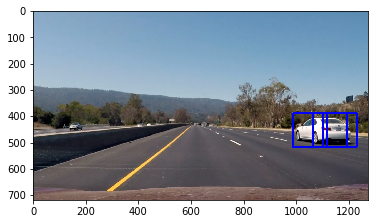

In [30]:
highway_img = mpimg.imread('test_images/test7.jpg')
draw_image = np.copy(highway_img)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

y_start_stop = [350, None] # Min and max in y to search in slide_window()

windows = slide_window(highway_img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.7, 0.7))

hot_windows = search_windows(highway_img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


The model is behaving decently well, so let's save it to a pickle file.

In [24]:
import pickle

In [25]:
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["color_space"] = color_space
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
dist_pickle["hog_channel"] = hog_channel
pickle.dump(dist_pickle, open("dist_pickle.p", "wb"))